`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import random

In [2]:
xrootdstr = 'root://cmseos.fnal.gov//'

In [3]:
qcdfilename = 'flatqcd.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr + s.strip() for s in f.readlines()]

In [5]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [6]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=110., maxMSD=250., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019):
        
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        self.ttagcats = ["0t", "1t", "2t"]   # 0, 1, or both jets t tagged
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ b+y+t for b,y,t in itertools.product( self.btagcats, self.ycats, self.ttagcats) ]
        self.anacats += ['pretag']
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        ht_axis = hist.Bin("h_ak4ht", r"AK4 Jet H_{T} [GeV]", 50, 0, 5000)
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)
        jetn3b1_axis = hist.Bin("n3b1", r"Jet N3", 50, 0, 1)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
#        ttag_numerator_axis = hist.Bin("ttag_numerator", )
#        ttag_denominator_axis = hist.Bin("ttag_denominator", )
#        antitag_numerator_axis = hist.Bin("antitag_numerator", )

        self._accumulator = processor.dict_accumulator({
            'h_ak4ht'  : hist.Hist("Counts", dataset_axis, cats_axis, ht_axis),
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
#            'jeteta':
#            'jetphi':
#            'jetsoftdrop':
#            'ttag_numerator': hist.Hist("Counts", ttag_numerator_axis),
#            'ttag_denominator': hist.Hist("Counts"),
#            'antitag_numerator': hist.Hist("Counts", antitag_numerator_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    """Define a function that 'tags' the ttbar candidate jets; Applied to every pair of jet candidates"""
    def TAT(self, jetcand, tagger_switch): # Ttagger and Anti Tagger
        tau32 = np.where(jetcand.tau2>0,jetcand.tau3/jetcand.tau2, 0 )
        passTau32 = tau32 < self.tau32Cut
        AntiPassTau32 = tau32 > self.tau32Cut
        #passSoftDrop = jetcand.msoftdrop != None & self.minMSD < jetcand.msoftdrop < self.maxMSD
        passSoftDrop = np.logical_and(self.minMSD < jetcand.msoftdrop, jetcand.msoftdrop < self.maxMSD)
        ttag = passTau32 & passSoftDrop
        antitag = AntiPassTau32 & passSoftDrop
        if tagger_switch == 0:
            return ttag
        elif tagger_switch == 1:
            return antitag
            

    def process(self, df):
        
        output = self.accumulator.identity()
        
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB']
            )
        
        #weight = JaggedArray.fromcounts(
        #    np.ones_like(df['Generator_binvar'],dtype=int),
        #    df['Generator_weight']
        #)
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += FatJets.size

        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()
        
        jet_id = (FatJets.jetId > 0)
        
        #print("jet_id[:,0]", jet_id[:,0])          
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5)
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()
        
        evtweights = evtweights[twoFatJets]
        ttbarcands = FatJets[:,0:2].distincts()

        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]

        
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut]        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        # Now get the analysis categories. 
        # They are (central, forward) cross (0b,1b,>=2b) cross (0t, 1t, 2t) 
        
        """Define center region and forward region possibilities"""
        cen = np.abs(ttbarcands.i0.p4.y - ttbarcands.i1.p4.y) < 1.0
        fwd = np.logical_not(cen)
        
        """Define the btag requirement for individual jet candidates (Used to identify b-tagged jets)""" 
        btag_i0 = (ttbarcands.i0.btagDeepB > 0.7)
        btag_i1 = (ttbarcands.i1.btagDeepB > 0.7)
        
              
        """Randomly select one of the two subjets from the ttbar candidates"""
        rand_cand = random.choice([ttbarcands.i0, ttbarcands.i1]) # Get jet pt of this for plots
        other_cand = np.logical_not(rand_cand)
            
        """Define the tagger switches for TAT function (for easy reading)"""
        ttagger = 0
        antitagger = 1
        
        """Define the ttag requirement for random individual jet candidate (Used to identify t-tagged jets)"""
        ttag_first = self.TAT(rand_cand, ttagger) # 1st randomly selected jet goes through t tagger 
        ttag_second = self.TAT(other_cand, ttagger) # 2nd jet goes through t tagger
        anti_ttag_first = self.TAT(rand_cand, antitagger) 
        anti_ttag_second = self.TAT(other_cand, antitagger) # Get jet pt
        
        """Keep track of all ttbar candidate pairs that are t-tagged (numerator)
            compared with the total number of ttbar candidate pairs found kinematically (denominator).
        Repeat using the anti t-tagger and define the mistag rate"""
        # antitag_first with tag_second and vice-versa...
        # i.e. np.logical_and(antitag_first, ttag_second) is condition 1
        
#        output["ttag_denominator"].fill(1) # Fill with number of all ttbar candidate pairs      
#        if ttag_first & ttag_second: # if both jet candidates were successfully t tagged...
#            ttag_numerator.fill(1) # 'One' means 'successfully tagged'
#        else:
#            ttag_numerator.fill(-1) # 'Negative' means 'not tagged'
        
        """Repeat for the anti t tagger"""       
#        if anti_ttag_first & anti_ttag_second:
#            antitag_numerator.fill(1)
#        else: 
#            antitag_numerator.fill(-1)
             
        """Define tagger possibilities for b's and t's (0b,1b,2b, 0t,1t,2t)"""
        btag0 = np.logical_not(btag_i0) & np.logical_not(btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        ttag0 = np.logical_not(ttag_first) & np.logical_not(ttag_second)
        ttag1 = np.logical_or(ttag_first, ttag_second)
        ttag2 = np.logical_and(ttag_first, ttag_second)
        
        # (cen & btag0 & antitag)
        # (cen & btag1 & antitag)...
        """List all of the possible categories"""
        cat000 = (cen & btag0 & ttag0).flatten()
        cat001 = (cen & btag0 & ttag1).flatten()
        cat002 = (cen & btag0 & ttag2).flatten()
        
        cat010 = (cen & btag1 & ttag0).flatten()
        cat011 = (cen & btag1 & ttag1).flatten()
        cat012 = (cen & btag1 & ttag2).flatten()
        
        cat020 = (cen & btag2 & ttag0).flatten()
        cat021 = (cen & btag2 & ttag1).flatten()
        cat022 = (cen & btag2 & ttag2).flatten()
        
        cat100 = (fwd & btag0 & ttag0).flatten()
        cat101 = (fwd & btag0 & ttag1).flatten()
        cat102 = (fwd & btag0 & ttag2).flatten()
        
        cat110 = (fwd & btag1 & ttag0).flatten()
        cat111 = (fwd & btag1 & ttag1).flatten()
        cat112 = (fwd & btag1 & ttag2).flatten()
        
        cat120 = (fwd & btag2 & ttag0).flatten()
        cat121 = (fwd & btag2 & ttag1).flatten()
        cat122 = (fwd & btag2 & ttag2).flatten()
        
        pretag = [True] * len(cen)
        
#        cat1 = (fwd & btag0).flatten()
#        cat2 = (cen & btag1).flatten()
#        cat3 = (fwd & btag1).flatten()
#        cat4 = (cen & btag2).flatten()
#        cat5 = (fwd & btag2).flatten()
        
#        cats = [cat0,cat1,cat2,cat3,cat4,cat5,pretag]
        cats = [cat000,cat001,cat002,
                cat010,cat011,cat012,
                cat020,cat021,cat022,
                cat100,cat101,cat102,
                cat110,cat111,cat112,
                cat120,cat121,cat122,pretag]
    
        labels_and_categories = dict(zip( self.anacats, cats ))
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        
        for ilabel,icat in labels_and_categories.items():
            output['cutflow'][ilabel] += np.sum(icat)
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=evtweights[icat].flatten())
        
        
        return output

    
    def postprocess(self, accumulator):
        return accumulator

In [7]:
tstart = time.time()

fileset = {
    'TTbar':ttbarfiles,
    #'QCD':qcdfiles # QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8
    #'ZZ to 4mu': [
    #    'data/ZZTo4mu.root'
    #]
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(),
                                  #executor=processor.dask_executor,
                                  executor=processor.iterative_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'workers': 4},
                                  chunksize=50000, maxchunks=1
                                 )

elapsed = time.time() - tstart
print(output)

['0bcen0t', '0bcen1t', '0bcen2t', '0bfwd0t', '0bfwd1t', '0bfwd2t', '1bcen0t', '1bcen1t', '1bcen2t', '1bfwd0t', '1bfwd1t', '1bfwd2t', '2bcen0t', '2bcen1t', '2bcen2t', '2bfwd0t', '2bfwd1t', '2bfwd2t', 'pretag']



{'h_ak4ht': <Hist (dataset,anacat,h_ak4ht) instance at 0x7f1afdae5350>, 'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7f1afd0de450>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f1af774e8d0>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7f1afc057050>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 49677, 'two FatJets': 5638, 'jet id': 5635, 'jet kin': 1029, '>= one oneTTbar': 372, 'dPhi > 2.1': 181, '0bcen0t': 0, '0bcen1t': 0, '0bcen2t': 0, '0bfwd0t': 0, '0bfwd1t': 0, '0bfwd2t': 0, '1bcen0t': 0, '1bcen1t': 0, '1bcen2t': 0, '1bfwd0t': 87, '1bfwd1t': 44, '1bfwd2t': 0, '2bcen0t': 33, '2bcen1t': 12, '2bcen2t': 0, '2bfwd0t': 3, '2bfwd1t': 2, '2bfwd2t': 0, 'pretag': 181})}


/opt/conda/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,.5)}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}


/opt/conda/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw 

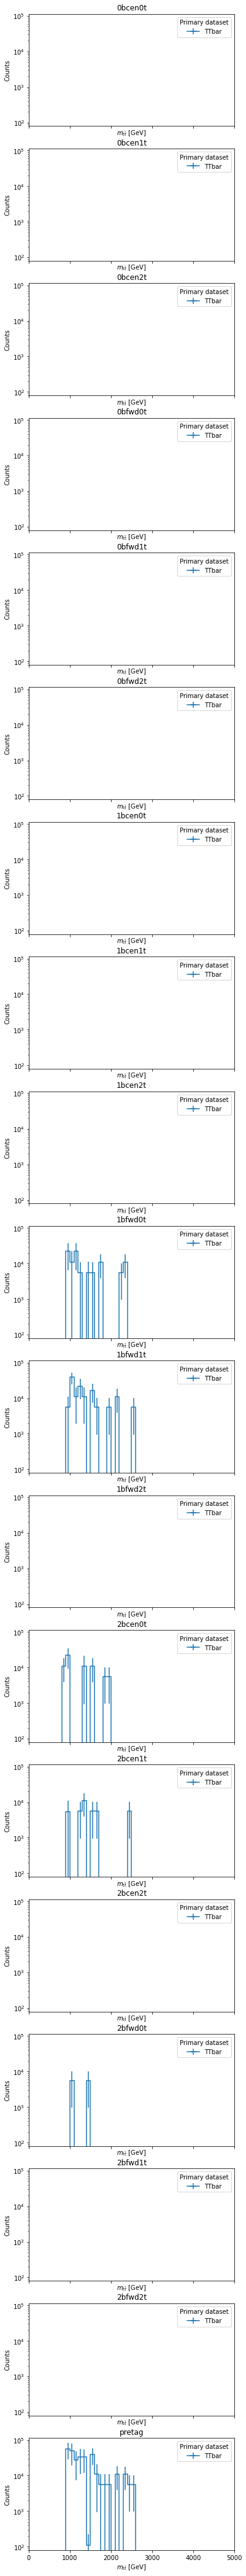

In [10]:
import matplotlib.pyplot as plt
ax = hist.plotgrid(output['ttbarmass'], row="anacat", overlay="dataset", stack=False
                                  #fill_opts=stack_fill_opts,
                                  #error_opts=stack_error_opts,
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
#    plt.savefig('/uscms_data/d1/acwillia/singularity/TestPlot_' + '' + '.png')
#plt.savefig('/uscms_data/d1/acwillia/singularity/TTagTestPlots.png')
#plt.savefig('/uscms_data/d1/acwillia/TTagTestPlots_backup.png')
    
#bx = hist.plot1d(ttag_numerator)
#for ibx in bx.flatten():
#    ibx.autoscale(axis='y')
#fig.show()

In [ ]:
print("Events/s:", output['cutflow']['all events']/elapsed)

In [ ]:
for i,j in output['cutflow'].items():
    print( '%20s : %12d' % (i,j) )

In [ ]:

#mapping = {
#    'QCD': ['QCD'],
#}
#output['ttbarmass'].group("dataset", hist.Cat("dataset", "dataset"), mapping)
#hist_noDS = output['ttbarmass_pretag'].integrate('dataset')
